In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import RecurrentNetwork, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
import pyarrow
#import fastparquet

In [5]:
train_data = pd.read_csv("../data/train_data.csv")

TurbList = []
for i in (sorted(pd.unique(train_data["TurbID"]))):
    tmp = train_data[train_data["TurbID"] == i]
    tmp.reset_index(inplace=True,drop=True)
    TurbList.append(tmp)
dataset = TurbList[20][:]

In [5]:
pytorch_forecasting = []
for dataset in TurbList:
    dataset = dataset.drop(columns=["Itmp","Ndir","Pab1","Day","Etmp","Pab2","Pab3","Prtv","Tmstamp"])
    dataset.fillna(method = 'bfill',inplace=True)
    dataset = pd.concat([dataset[:9216], dataset[9648:]])
    # dataset = dataset.set_index(pd.date_range(start="2022-01-01", periods=len(dataset), freq="10T"),append=False)
    dataset["time_idx"] = list(range(len(dataset)))
    pytorch_forecasting.append(dataset)
total = pd.concat(pytorch_forecasting)

In [6]:
total = total.sort_values(by=['time_idx',"TurbID"])
total['TurbID'] = total['TurbID'].astype("string")
total['TurbID'] = total['TurbID'].astype('category')
total = total.reset_index(drop=True)

In [21]:
max_prediction_length = 288
max_encoder_length = 24

training_cutoff = total["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    total[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Patv",
    group_ids=["TurbID"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["TurbID"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],

     time_varying_known_reals=["time_idx"],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Wspd",
        "Wdir",
        "Patv",
    ],
    target_normalizer=GroupNormalizer(
        groups=["TurbID"], transformation="softplus"
    ),  # use softplus and normalize by group
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True,
)


In [22]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, total, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [18]:
# # convert the dataset to a dataloader
# dataloader = training.to_dataloader(batch_size=4)

# # and load the first batch
# x, y = next(iter(dataloader))
# print("x =", x)
# print("\ny =", y)
# print("\nsizes of x =")
# for key, value in x.items():
#     print(f"\t{key} = {value.size()}")

In [303]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = RecurrentNetwork.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    # attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    #output_size=7,  # 7 quantiles by default
    # static_categoricals = ["TurbID"],
    # x_reals = ["Patv"],
    # embedding_labels = ["TurbID"],
    
    allowed_encoder_known_variable_names = ["TurbID"],
    embedding_labels  = ["TurbID"],
    # time_varying_reals_encoder = [
    #     #"time_idx",
    #     "Wspd",
    #     "Wdir"
    #     #"Patv"
    # ],
    time_varying_reals_decoder = [
        #"time_idx",
        "Wspd",
        "Wdir",
        # "Patv"
    ],
    loss=SMAPE(),
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 3.6k


Finding best initial lr: 100%|██████████| 100/100 [05:54<00:00,  3.55s/it]
Restoring states from the checkpoint path at c:\Users\kdy\inha_ai_challenge\PytorchForecasting\.lr_find_b192d0d3-58e1-431c-86c4-55fdcfd5da3c.ckpt


suggested learning rate: 1.2302687708123814


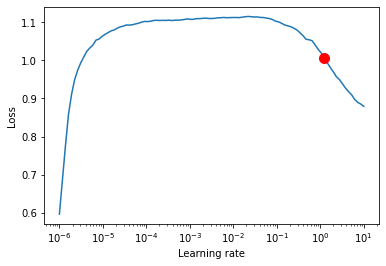

In [51]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [55]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = RecurrentNetwork.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    # attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    #output_size=7,  # 7 quantiles by default
    # x_reals = ["Patv"],
    # embedding_labels = ["TurbID"],

    allowed_encoder_known_variable_names = ["TurbID"],
    embedding_labels  = ["TurbID"],
    # time_varying_reals_encoder = [
    #     #"time_idx",
    #     "Wspd",
    #     "Wdir"
    #     #"Patv"
    # ],
    time_varying_reals_decoder = [
        #"time_idx",
        "Wspd",
        "Wdir",
        # "Patv"
    ],
    loss=SMAPE(),
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 3.6k


In [56]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | SMAPE          | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 3.6 K 
4 | output_projector | Linear         | 17    
----------------------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 31/31 [01:27<00:00,  2.83s/it, loss=0.222, v_num=3, train_loss_step=0.211, val_loss=0.472, train_loss_epoch=0.224]


In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [192]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = RecurrentNetwork.load_from_checkpoint(best_model_path)

In [300]:
pytorch_forecasting = []
for dataset in TurbList:
    dataset = dataset.drop(columns=["Itmp","Ndir","Pab1","Day","Etmp","Pab2","Pab3","Prtv","Tmstamp"])
    dataset.fillna(method = 'bfill',inplace=True)
    dataset = dataset[-288:]
    dataset.reset_index(inplace=True,drop=True)
    dataset.reset_index(inplace=True)
    # dataset = dataset.set_index(pd.date_range(start="2022-01-01", periods=len(dataset), freq="10T"),append=False)
    dataset["time_idx"] = list(range(len(dataset)))
    pytorch_forecasting.append(dataset)

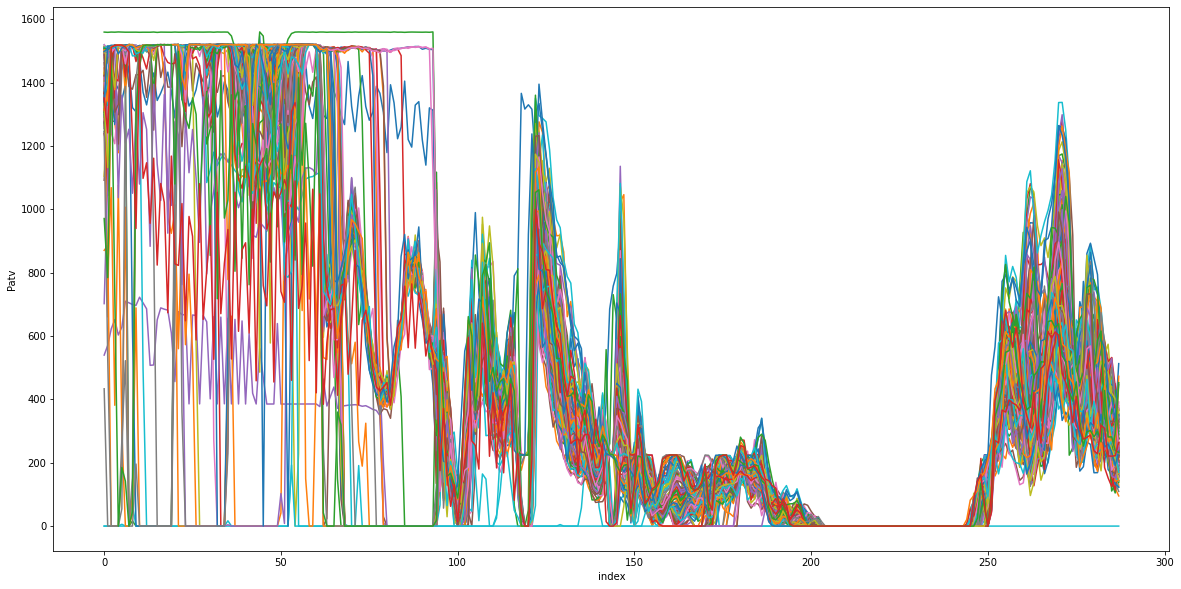

In [301]:
plt.figure(figsize=(20,10))
for i in pytorch_forecasting[:]:
    tp = i
    sns.lineplot(x='index', y='Patv', data=tp, ci=None)
plt.show()

In [239]:
test = pd.concat(pytorch_forecasting)
test = test.sort_values(by=['time_idx',"TurbID"])
test['TurbID'] = test['TurbID'].astype("string")
test['TurbID'] = test['TurbID'].astype('category')
test = test.reset_index(drop=True)

In [240]:
training = TimeSeriesDataSet(
    test,
    time_idx="time_idx",
    target="Patv",
    group_ids=["TurbID"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=24,
    min_prediction_length=288,
    max_prediction_length=288,
    time_varying_unknown_reals=[
        "Wspd",
        "Wdir",
        "Patv",
    ],
    target_normalizer=GroupNormalizer(
        groups=["TurbID"], transformation="softplus"
    ),
)

In [241]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
test_dataset = TimeSeriesDataSet.from_dataset(training, test, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [242]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_tft.predict(test_dataloader)
(actuals - predictions).abs().mean()

tensor(310.3202)

In [278]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(test_dataloader, mode="prediction", return_index=True)

In [288]:
raw_predictions[0].shape

torch.Size([134, 288])

In [273]:
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [274]:
sample_submission["Patv"] = raw_predictions.reshape(-1)
sample_submission.to_csv("./submit.csv", index = False)

In [275]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [276]:
test = []
for i in (sorted(pd.unique(sample_submission["TurbID"]))):
    tmp = sample_submission[sample_submission["TurbID"] == i].drop(columns=["index"])
    tmp.reset_index(inplace=True,drop=True)
    tmp.reset_index(inplace=True)
    test.append(tmp)

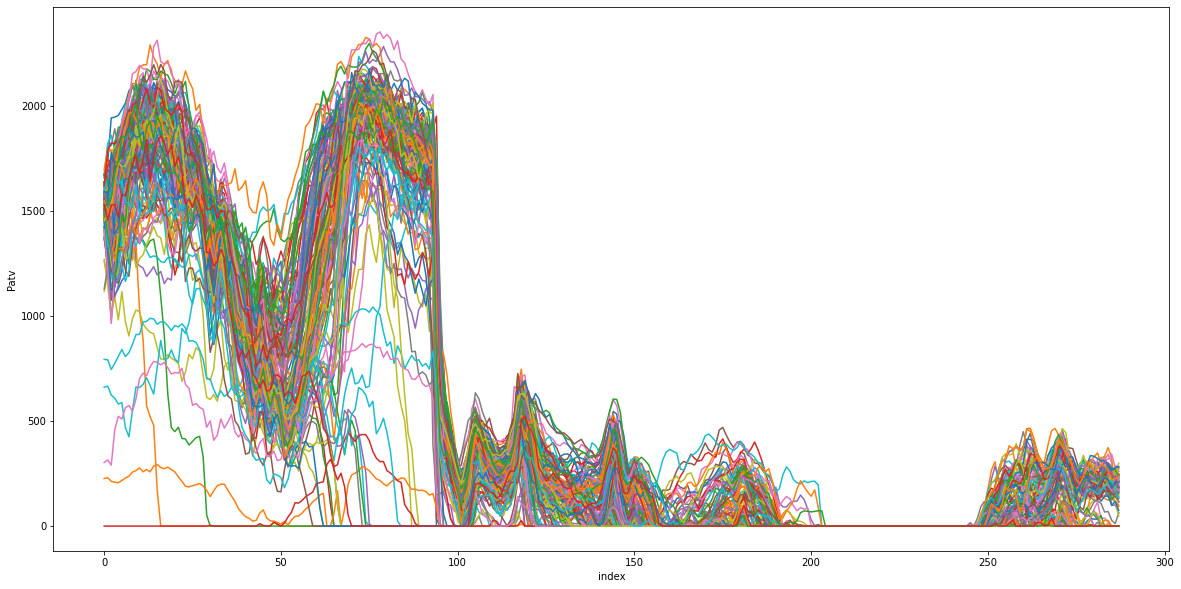

In [277]:
plt.figure(figsize=(20,10))
for i in test[:]:
    tp = i[i["Day"]==201].index[0]
    t = i[tp:tp+144]   
    tp2 = i[i["Day"]==202].index[0]
    t2 = i[tp2:tp2+144]
    tp = pd.concat([t,t2])
    tp = tp.fillna(method = 'bfill')
    sns.lineplot(x='index', y='Patv', data=tp, ci=None)
plt.show()